# Annulation d'écho

Un exemple très classique de filtrage adaptatif utile dans le vie de tous les jours concerne la téléphonie main-libre. En effet lorsque le mode haut-parleur du téléphone est activé (ou lors d'une conférence audio, au hasard, via `Discord`...) l'interlocuteur devrait entendre 
un écho indésirable de sa propre voix, ou pire un très désagréable effet Larsen (le haut-parleur étant à proximité du micro) ! Pourquoi n'est ce pas le cas en pratique ?

### `Signal processing` inside 

Ces dispositifs disposent d'un système pour supprimer l'écho (voir pex les paramètres de l'application `Discord`). L'écho $v$ peut en effet se modéliser comme une opération de filtrage linéaire du signal $y$ en sortie du haut parteur. Plus précisemment, on a 

$$v =   h_n \ast y $$ 

où $h_n$ réprésente la réponse du canal de propagation du signal audio depuis le haut-parleur jusqu'au micro. Ce canal dépend de l'environnement extérieur et de la localisation (trajet), et, est susceptible d'évoluer dans le temps (imaginez que l'environnement évolue, ou que le téléphone soit déplacé). 
Puisque l'on dispose d'une version (déformée) du signal d'écho $v$ à supprimer, le signal $y$ qui sort du haut-parleur, un filtre adaptatif est particulièrement approprié afin d'estimer cet écho, puis de le supprimer du signal enregistré par le micro.
Le filtre LMS, qui a l'avantage d'ếtre performant tout en étant très simple à  mettre en oeuvre, est ainsi couramment employé pour cette tâche. Ce dispositif est schématisé dans la figure ci-dessous:

![schéma suppression d'écho](img/schema_echo.png)

où l'on note
- $x=s+v$ : l'enregistrement par le micro du signal utile $s$ à transmettre + le bruit $v$ dû à l'écho
- $y$ : la référence `bruit seul`, qui représente le signal  du haut-parleur

La flèche qui traverse le filtre symbolise enfin l'adaptativité du filtre : les coefficients sont en effet remis à jour à partir de l'erreur de prédiction commise.

*La cellule ci-dessous est un préambule afin de charger les modules utiles*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # Afficher des graphiques
import numpy as np # Représentation des tableaux par ndarray
import scipy.io # Lire les données en .mat

## Read the two signals: speakers + micro

In [2]:
fs = 16000 #Hz
file = scipy.io.loadmat('data/les2voies.mat')
y_HP = np.array(file['yn_HP'], dtype=float).reshape(-1) # speakers
x_micro = np.array(file['zn_somme'], dtype=float).reshape(-1) # micro + echo from speakers

##  Play the speakers signal (man voice)

In [3]:
from IPython.display import Audio
Audio(y_HP, rate=fs)

##  Play the two voices: speakers (man voice) + micro (woman voice) signals

In [4]:
from IPython.display import Audio
Audio(x_micro, rate=fs)

In [5]:
N = len( x_micro )  # number of samples
nbtaps = 60 # length of the LMS filter
borne_mu=  2 / ( nbtaps * np.mean(  y_HP**2 ) ) # upper bound for the adaptive stepsize 
mu = borne_mu / 30  # stepsize  

In [6]:
echo_hat = np.zeros(N) # the estimated noise (echo)
error = np.zeros(N)  # prediction error
w = np.zeros(nbtaps) # filter coeffs

In [7]:
# Build and apply LMS filter
for k in range(N):
    # fill the signal with zeros to filter the first samples
    if ( k < nbtaps ):
        yk = np.concatenate( ( y_HP[k::-1], np.zeros(nbtaps-k-1) ) )
    else:
        yk = y_HP[k:k-nbtaps:-1]
    # prediction error based on the previous coeffs (innovation)
    error[k] = x_micro[k] - np.dot( w , yk )
    # update the coeffs
    w = w + mu * error[k] * yk 
    # estimate the echo
    echo_hat[k] = np.dot( w , yk )

In [8]:
s_hat= x_micro - echo_hat # restored signal: echo cancellation

##  Display and play the estimated signals

### Echo 

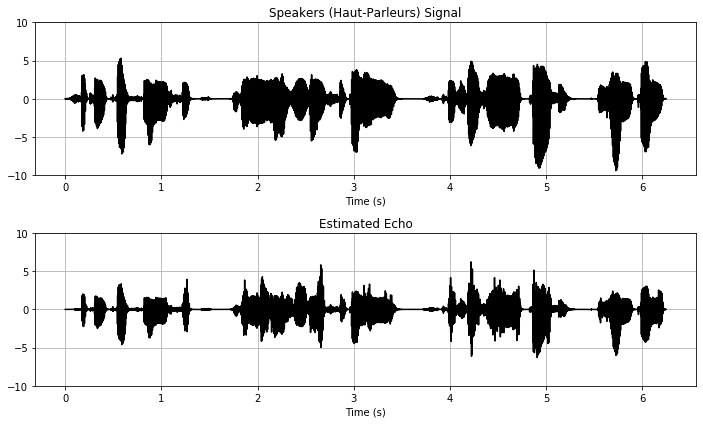

In [9]:
time = np.arange(N)/fs
f, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(time, y_HP, 'k-')
plt.title("Speakers (Haut-Parleurs) Signal")
plt.xlabel("Time (s)")
plt.ylim(-10,10)
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time, echo_hat, 'k-')
plt.title("Estimated Echo")
plt.xlabel("Time (s)")
plt.ylim(-10,10)
plt.tight_layout()

In [10]:
from IPython.display import Audio
Audio(echo_hat, rate=fs)

# Signal with echo cancellation

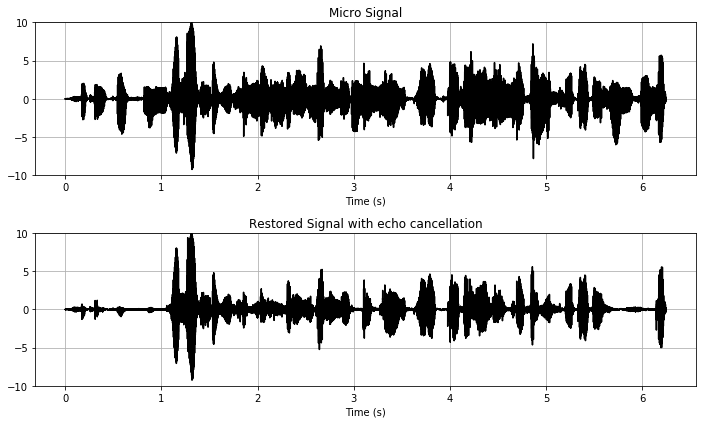

In [11]:
time = np.arange(N)/fs
f, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(time, x_micro, 'k-')
plt.title("Micro Signal")
plt.xlabel("Time (s)")
plt.ylim(-10,10)
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time, s_hat, 'k-')
plt.title("Restored Signal with echo cancellation")
plt.xlabel("Time (s)")
plt.ylim(-10,10)
plt.tight_layout()

In [12]:
from IPython.display import Audio
Audio(s_hat, rate=fs)

In [13]:
# play original signal (to compare)
from IPython.display import Audio
Audio(x_micro, rate=fs)

### Questions
- Le signal d'écho est-il toujours parfaitement annulé ? Comment l'expliquer ?
- Pourquoi le résidu du signal d'écho dans le signal débruité est-il plus important au début ?
- Comment expliquer que l'écho estimé contienne parfois une partie du signal utile (voix de la femme) ?
- Que se passe t'il si l'on diminue trop le pas d'adapativité mu (prendre pex $\texttt{mu}/50$) ?
- A l'inverse que se passe t'il si l'on augmente trop ce pas (prendre pex  $4\times \texttt{mu}$) ?
- Comment expliquer que le filtre diverge alors que la borne théorique n'est pas atteinte ?
- Essayez différentes valeurs de mu afin de trouver le meilleur compromis pour ces signaux 